# Train

### Library setups and imports

In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflowjs as tfjs
import matplotlib.pyplot as plt
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D

2021-10-28 21:05:44.015060: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-28 21:05:44.015076: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Parameters

In [2]:
USE_DOWNLOADED_SET = True
DOWNLOADED_SET_URL = 'https://hkinsley.com/static/downloads/bci/model_data_v2.7z'
DATA_DIR = 'data/mask-iv-openbci' if USE_DOWNLOADED_SET else 'data/personal'
LABELS = {"left": [1, 0, 0], "none": [0, 1, 0], "right": [0, 0, 1]}
INPUT_SHAPE=(-1, 8, 60)

### Data loading

In [3]:
def generate_dataset(is_validation_data):
    dataset = []
    path = os.path.join(DATA_DIR)
    subdir = 'validation_data/' if is_validation_data else 'data/'

    for label in LABELS:
        label_dir = os.path.join(path, subdir, label)
        for FILE in os.listdir(label_dir):
            if USE_DOWNLOADED_SET:
                ffts = np.load(os.path.join(DATA_DIR, subdir, label, FILE))
                for fft_data in ffts:
                    dataset.append([fft_data[:8], LABELS[label]])
            else:
                fft_data = np.load(os.path.join(DATA_DIR, FILE))
                dataset.append([fft_data[:8], label])
        
        random.shuffle(dataset)
    return dataset

In [4]:
training = generate_dataset(False)
validation = generate_dataset(True)

train_x = []
train_y = []
for x, y in training:
    train_x.append(x)
    train_y.append(y)
    
val_x = []
val_y = []
for x, y in validation:
    val_x.append(x)
    val_y.append(y)

train_x = np.array(train_x).reshape(INPUT_SHAPE)
val_x = np.array(val_x).reshape(INPUT_SHAPE)

train_y = np.array(train_y)
val_y = np.array(val_y)

### Neural network definition

In [5]:
model = Sequential([
    Conv1D(32, (2), activation='relu', input_shape=train_x.shape[1:], padding='same'),
    MaxPooling1D(pool_size=(2)),
    Conv1D(128, (2), activation='relu', padding='same'),
    MaxPooling1D(pool_size=(2)),
    Conv1D(64, (4), activation='relu', padding='same'),
    MaxPooling1D(pool_size=(2)),
    Dropout(0.4),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer='l1'),
    Dense(3, activation=tf.nn.softmax)
])

2021-10-28 21:05:52.286764: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-28 21:05:52.287138: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-28 21:05:52.287180: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-10-28 21:05:52.287218: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-10-28 21:05:52.287256: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [6]:
filepath="tmp/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [7]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 8, 32)             3872      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4, 32)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4, 128)            8320      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2, 128)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2, 64)             32832     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1, 64)             0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 64)             0

In [9]:
with tf.device('/CPU:0'):
    history = model.fit(train_x, train_y, epochs=30, batch_size=1024, validation_data=(val_x, val_y), callbacks=[model_checkpoint_callback])

2021-10-28 21:05:53.169101: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 546480000 exceeds 10% of free system memory.
2021-10-28 21:05:53.628546: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
277/278 [============================>.] - ETA: 0s - loss: 7.2949 - accuracy: 0.3817

2021-10-28 21:05:56.952528: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 67680000 exceeds 10% of free system memory.


278/278 [==============================] - 3s 11ms/step - loss: 7.2914 - accuracy: 0.3817 - val_loss: 6.3101 - val_accuracy: 0.3532

Epoch 00001: val_accuracy improved from -inf to 0.35316, saving model to tmp/weights-improvement-01-0.35.hdf5
Epoch 2/30
278/278 [==============================] - 3s 9ms/step - loss: 5.3676 - accuracy: 0.4234 - val_loss: 4.6046 - val_accuracy: 0.3471

Epoch 00002: val_accuracy did not improve from 0.35316
Epoch 3/30
278/278 [==============================] - 3s 9ms/step - loss: 3.7916 - accuracy: 0.4424 - val_loss: 3.2183 - val_accuracy: 0.3608

Epoch 00003: val_accuracy improved from 0.35316 to 0.36082, saving model to tmp/weights-improvement-03-0.36.hdf5
Epoch 4/30
278/278 [==============================] - 3s 9ms/step - loss: 2.5713 - accuracy: 0.4601 - val_loss: 2.1848 - val_accuracy: 0.3808

Epoch 00004: val_accuracy improved from 0.36082 to 0.38082, saving model to tmp/weights-improvement-04-0.38.hdf5
Epoch 5/30
278/278 [===========================

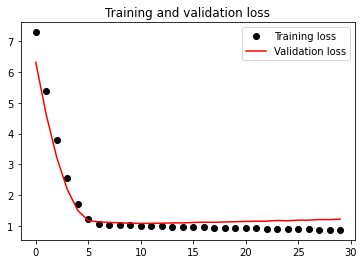

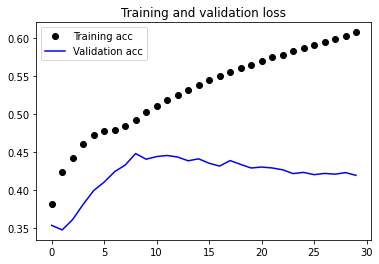

In [10]:
loss = plt.figure(1)
history_loss = history.history['loss']
history_val_loss = history.history['val_loss']
epochs = range(len(history_loss))

plt.plot(epochs, history_loss, 'ko', label='Training loss')
plt.plot(epochs, history_val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

loss = plt.figure(2)
history_acc = history.history['accuracy']
history_val_acc = history.history['val_accuracy']
epochs = range(len(history_loss))

plt.plot(epochs, history_acc, 'ko', label='Training acc')
plt.plot(epochs, history_val_acc, 'b', label='Validation acc')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [12]:
model.save('models/tf')
tfjs.converters.save_keras_model(model, 'models/tfjs')

INFO:tensorflow:Assets written to: models/tf/assets
